In [1]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from scipy import stats
import os 
import scipy.io as sio
import re
import collections
import pandas as pd
from matplotlib.artist import setp 
import itertools
import pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('ggplot')

In [2]:
#file paths
base_dir = '/projects/nikhil/jlf/revision_data/adni_vol/'

dx_mat_file = 'ADNI_Screening_Dx.mat'
awol_vol_file_Batch1_L = 'ADNI_Screening_Batch1_Left_16-Jan-2015.mat'
awol_vol_file_Batch1_R = 'ADNI_Screening_Batch1_Right_16-Jan-2015.mat'
awol_vol_file_Batch2_L = 'ADNI_Screening_Batch2_Left_19-Jan-2015.mat'
awol_vol_file_Batch2_R = 'ADNI_Screening_Batch2_Right_19-Jan-2015.mat'
stpl_vol_file_L = 'ADNI_Screening_STAPLE_Left_12-Feb-2015.mat'
stpl_vol_file_R = 'ADNI_Screening_STAPLE_Right_12-Feb-2015.mat'
jlf_vol_file = 'adni_bl_vol_stats_ns'

MCI_conversion_IDx = 'MCI_1year_Dx_conversion_IDs.pkl'
batch1_idx_file = 'image_idx_batch1'
batch2_idx_file = 'image_idx_batch2'
stpl_idx_file = 'image_idx_stpl'

In [3]:
#Create Dx-subejct dictionaty 
mat_contents = sio.loadmat(base_dir + dx_mat_file)
Img_Dx_dict = collections.defaultdict(list)
for i in np.arange(mat_contents['ADNIScr_Dx'].shape[0]):
    Img_Idx = mat_contents['ADNIScr_Dx'][i,0][0][0]
    Dx = str(mat_contents['ADNIScr_Dx'][i,1][0])
    Img_Dx_dict['I' + str(Img_Idx)].append(Dx)

In [4]:
#Load Maj vote and AWoL vol
subx = 818
batch1_len = 323
awol_vols_L = np.zeros(subx)
awol_vols_R = np.zeros(subx)
maj_vols_L = np.zeros(subx)
maj_vols_R = np.zeros(subx)

mat_contents = h5.File(base_dir + awol_vol_file_Batch1_L)
awol_vols_L[:batch1_len] = np.squeeze(mat_contents['AwolVol'][:])
maj_vols_L[:batch1_len] = np.squeeze(mat_contents['majVol'][:])

mat_contents.close()
mat_contents = h5.File(base_dir + awol_vol_file_Batch1_R)
awol_vols_R[:batch1_len] = np.squeeze(mat_contents['AwolVol'][:])
maj_vols_R[:batch1_len] = np.squeeze(mat_contents['majVol'][:])
mat_contents.close()

mat_contents = h5.File(base_dir + awol_vol_file_Batch2_L)
awol_vols_L[batch1_len:] = np.squeeze(mat_contents['AwolVol'][:])
maj_vols_L[batch1_len:] = np.squeeze(mat_contents['majVol'][:])
mat_contents.close()

mat_contents = h5.File(base_dir + awol_vol_file_Batch2_R)
awol_vols_R[batch1_len:] = np.squeeze(mat_contents['AwolVol'][:])
maj_vols_R[batch1_len:] = np.squeeze(mat_contents['majVol'][:])
mat_contents.close()

#mean vols (L and R)
mean_awol_vols = np.mean([awol_vols_L,awol_vols_R])
mean_maj_vols = np.mean([maj_vols_L,maj_vols_R])

In [5]:
#img idx
with open(base_dir+batch1_idx_file) as f:
    batch1_idx = f.readlines()
    
with open(base_dir+batch2_idx_file) as f:
    batch2_idx = f.readlines()

with open(base_dir+stpl_idx_file) as f:
    stpl_idx = f.readlines()

In [6]:
#Load stpl vols
mat_contents = sio.loadmat(base_dir + stpl_vol_file_L)
stpl_vols_L = np.squeeze(mat_contents['STAPLE_Vol_Out'])
mat_contents = sio.loadmat(base_dir + stpl_vol_file_R)
stpl_vols_R = np.squeeze(mat_contents['STAPLE_Vol_Out'])

mean_stpl_vols = np.mean([stpl_vols_L,stpl_vols_R])


In [7]:
#Load JLF vols
with open(base_dir + jlf_vol_file) as f:
    content = f.readlines()
    
content_len = len(content)
jlf_sub_names = content[0:content_len:3]
jlf_vol_L = content[1:content_len:3]
jlf_vol_R = content[2:content_len:3]


In [40]:
# Group vols based on Dx

def groupVolDx(sub_names, vol_L_array, vol_R_array,format_sub_string):
    tbv_file_path = base_dir + 'ADNI1_1.5T_with_scaled_2.csv'
    csv_data = pd.read_csv(tbv_file_path,sep=';')
    baseline_adni1_data = csv_data[(csv_data.VISCODE =='bl')]

    dx_dict = pd.Series(baseline_adni1_data.DX.values,index=baseline_adni1_data.RID).to_dict()
    ICV_dict =  pd.Series(baseline_adni1_data.ICV.values,index=baseline_adni1_data.RID).to_dict()
    TBV_dict =  pd.Series(baseline_adni1_data.WholeBrain.values,index=baseline_adni1_data.RID).to_dict()
    Age_dict =  pd.Series(baseline_adni1_data.Age.values,index=baseline_adni1_data.RID).to_dict()
    Sex_dict =  pd.Series(baseline_adni1_data.Sex.values,index=baseline_adni1_data.RID).to_dict()
    
    meth_df = pd.DataFrame(columns=('ID', 'DX', 'Age', 'Sex', 'TBV', 'ICV', 'HC_L', 'HC_R', 'HC_LR'))
    Px_df = pd.DataFrame(columns=('ID', 'PX', 'Age', 'Sex', 'TBV', 'ICV', 'HC_L', 'HC_R', 'HC_LR'))
        
    id_image = re.compile('(?<=S)\d+_(.*?)(?=_)')
    Dx_vol_L_dict = collections.defaultdict(list)
    Dx_vol_R_dict = collections.defaultdict(list)
    Dx_vol_LR_dict = collections.defaultdict(list)
    
    Dx_vol_normICV_L_dict = collections.defaultdict(list)
    Dx_vol_normICV_R_dict = collections.defaultdict(list)
    Dx_vol_normICV_LR_dict = collections.defaultdict(list)
    
    Dx_vol_normTBV_L_dict = collections.defaultdict(list)
    Dx_vol_normTBV_R_dict = collections.defaultdict(list)
    Dx_vol_normTBV_LR_dict = collections.defaultdict(list)
    
    Dx_img_dict = collections.defaultdict(list)
    
    pkl_file = open(base_dir + MCI_conversion_IDx, 'rb')
    mci_conv_dict = pickle.load(pkl_file)
    mci_conv_list = mci_conv_dict['MCI_conv']
    mci_nonconv_list = mci_conv_dict['MCI_nonconv']
    Px_sub_vol_dict = collections.defaultdict(list)
    Px_sub_vol_normICV_dict = collections.defaultdict(list)
    Px_sub_vol_normTBV_dict = collections.defaultdict(list)
    
    for i,sub_name in enumerate(sub_names):
        if format_sub_string:
            sub_name = sub_name.rstrip()[1:-1] + '_suf.mnc'
                    
        #img_idx = re.search(id_image, sub_name).group(1)
        img_idx = int(sub_name.split('_')[3])
        sub_idx = sub_name.split('_')[1] + '_S_' + sub_name.split('_')[3]
        
        Dx = dx_dict[img_idx]
        #print Dx
        if len(Dx)<1:
            print "no matches: " + img_idx
        else:
            #if len(Dx)>1:
            #    print "more than 1 matches: " + img_idx
            if img_idx != 'I80930':  #remove this extra subject from jlf list to make arrays directly comparable
                
                cols = meth_df.columns
                #'ID', 'Age', 'Sex', 'TBV', 'ICV', 'HC_L', 'HC_R', 'HC_LR'  
                L_R_mean_vol = 0.5*(float(vol_L_array[i])+float(vol_R_array[i]))
                
                if L_R_mean_vol > 750: #Vol QC threshold
                    row = pd.Series([img_idx, dx_dict[img_idx], Age_dict[img_idx], Sex_dict[img_idx], ICV_dict[img_idx], 
                                          TBV_dict[img_idx],float(vol_L_array[i]),float(vol_R_array[i]),
                                          L_R_mean_vol], index=cols)
                    #add row to the table
                    meth_df.loc[len(meth_df)] = row
                
                    #Converters vs non-converters
                    if sub_idx in mci_conv_list:
                        Px_sub_vol_dict['mci_conv'].append(L_R_mean_vol)
                        if ~np.isnan(float(TBV_dict[img_idx])):
                            Px_sub_vol_normTBV_dict['mci_conv'].append(L_R_mean_vol/float(TBV_dict[img_idx]))
                            #create df for linear model used later
                            cols = Px_df.columns
                            #'ID', 'PX', 'Age', 'Sex', 'TBV', 'ICV', 'HC_L', 'HC_R', 'HC_LR'
                            row = pd.Series([img_idx, 1, Age_dict[img_idx], Sex_dict[img_idx], ICV_dict[img_idx], 
                                              TBV_dict[img_idx],float(vol_L_array[i]),float(vol_R_array[i]),
                                              L_R_mean_vol], index=cols)
                            #add row to the table
                            Px_df.loc[len(meth_df)] = row

                        if ~np.isnan(float(ICV_dict[img_idx])): 
                            Px_sub_vol_normICV_dict['mci_conv'].append(L_R_mean_vol/float(ICV_dict[img_idx]))                                                            


                    elif sub_idx in mci_nonconv_list:
                        Px_sub_vol_dict['mci_stable'].append(L_R_mean_vol)
                        if ~np.isnan(float(TBV_dict[img_idx])):
                            Px_sub_vol_normTBV_dict['mci_stable'].append(L_R_mean_vol/float(TBV_dict[img_idx]))
                            #create df for linear model used later
                            cols = Px_df.columns
                            #'ID', 'PX', 'Age', 'Sex', 'TBV', 'ICV', 'HC_L', 'HC_R', 'HC_LR'
                            row = pd.Series([img_idx, 0, Age_dict[img_idx], Sex_dict[img_idx], ICV_dict[img_idx], 
                                              TBV_dict[img_idx],float(vol_L_array[i]),float(vol_R_array[i]),
                                              L_R_mean_vol], index=cols)
                            #add row to the table
                            Px_df.loc[len(meth_df)] = row

                        if ~np.isnan(float(ICV_dict[img_idx])): 
                            Px_sub_vol_normICV_dict['mci_stable'].append(L_R_mean_vol/float(ICV_dict[img_idx]))


                    Dx_img_dict[Dx].append(img_idx)
                    Dx_vol_L_dict[Dx].append(float(vol_L_array[i]))
                    Dx_vol_R_dict[Dx].append(float(vol_R_array[i]))
                    Dx_vol_LR_dict[Dx].append(L_R_mean_vol)

                    #Normalized vols based on ICV / TBV 
                    if ~np.isnan(float(ICV_dict[img_idx])): 
                        Dx_vol_normICV_L_dict[Dx].append(float(vol_L_array[i])/float(ICV_dict[img_idx]))
                        Dx_vol_normICV_R_dict[Dx].append(float(vol_R_array[i])/float(ICV_dict[img_idx]))
                        Dx_vol_normICV_LR_dict[Dx].append(L_R_mean_vol/float(ICV_dict[img_idx]))


                    if ~np.isnan(float(TBV_dict[img_idx])): 
                        Dx_vol_normTBV_L_dict[Dx].append(float(vol_L_array[i])/float(TBV_dict[img_idx]))
                        Dx_vol_normTBV_R_dict[Dx].append(float(vol_R_array[i])/float(TBV_dict[img_idx]))
                        Dx_vol_normTBV_LR_dict[Dx].append(L_R_mean_vol/float(TBV_dict[img_idx]))

                    
    return {'Dx_img_dict':Dx_img_dict,'Dx_vol_L_dict':Dx_vol_L_dict, 'Dx_vol_R_dict':Dx_vol_R_dict, 
            'Dx_vol_LR_dict':Dx_vol_LR_dict, 'Dx_vol_normICV_L_dict':Dx_vol_normICV_L_dict,
            'Dx_vol_normICV_R_dict':Dx_vol_normICV_R_dict,'Dx_vol_normICV_LR_dict':Dx_vol_normICV_LR_dict,
            'Dx_vol_normTBV_LR_dict':Dx_vol_normTBV_LR_dict,'df':meth_df, 'Px_df':Px_df, 'Px_sub_vol_dict':Px_sub_vol_dict,
            'Px_sub_vol_normICV_dict':Px_sub_vol_normICV_dict,'Px_sub_vol_normTBV_dict':Px_sub_vol_normTBV_dict}

def getCohens_d(data1, data2):
    sampx_1 = len(data1)
    sampx_2 = len(data2)
    mean_1 = np.mean(data1)
    mean_2 = np.mean(data2)
    std_1 = np.std(data1)
    std_2 = np.std(data1)
    s_2 = ((sampx_1-1)*(std_1 ** 2) + (sampx_2-1)*(std_2 ** 2))/(sampx_1+sampx_1-2)
    cohens_d = np.abs(mean_1-mean_2)/np.sqrt(s_2)
    #cohens_d = (np.mean(data1) - np.mean(data2)) / (np.sqrt((np.std(data1) ** 2 + np.std(data2) ** 2) / 2))
    return cohens_d

def getPairwiseStats(Dx_vol_dict,Dx_grps):    
    Dx_pairs = list(itertools.combinations(Dx_grps, 2))
    cohen_dict = {}
    signif_level = {}
    signif_dict = {}
    for pair in Dx_pairs:
        pair_name = pair[0] + ' v ' + pair[1]        
        cohens_d = getCohens_d(Dx_vol_dict[pair[0]],Dx_vol_dict[pair[1]])
        t_stat = stats.ttest_ind(Dx_vol_dict[pair[0]],Dx_vol_dict[pair[1]])
        signif_str=''
        if t_stat[1] < 0.001:
            signif_str = '***'
        elif t_stat[1] < 0.01:
            signif_str = '**'
        elif t_stat[1] < 0.05:
            signif_str = '*'
        else:
            signif_str = ''
            
        cohen_dict[pair_name] = cohens_d
        signif_level[pair_name] = signif_str
        signif_dict[pair_name] = t_stat[1]
        
    return {'signif_level':signif_level,'signif_dict':signif_dict, 'cohen_dict':cohen_dict}

In [41]:
# Group volumes by Dx
#collect total volume and normalized volumes
#also collecte df comrpsing age,sex,tbf,icv,HC vols for all subjects per method
from collections import defaultdict

format_sub_string = True
print 'maj'
result = groupVolDx(batch1_idx+batch2_idx,maj_vols_L,maj_vols_R,format_sub_string)
Dx_vol_LR_dict_maj = result['Dx_vol_LR_dict']
Dx_vol_normICV_LR_dict_maj = result['Dx_vol_normICV_LR_dict']
Dx_vol_normTBV_LR_dict_maj = result['Dx_vol_normTBV_LR_dict']
Px_vol_LR_dict_maj = result['Px_sub_vol_dict']
Px_vol_LR_normTBV_dict_maj = result['Px_sub_vol_normTBV_dict']
Px_vol_LR_normICV_dict_maj = result['Px_sub_vol_normICV_dict']
maj_df = result['Px_df'].copy()

print 'awol'
result = groupVolDx(batch1_idx+batch2_idx,awol_vols_L,awol_vols_R,format_sub_string)
Dx_vol_LR_dict_awol = result['Dx_vol_LR_dict']
Dx_vol_normICV_LR_dict_awol = result['Dx_vol_normICV_LR_dict']
Dx_vol_normTBV_LR_dict_awol = result['Dx_vol_normTBV_LR_dict']
Px_vol_LR_dict_awol = result['Px_sub_vol_dict']
Px_vol_LR_normTBV_dict_awol = result['Px_sub_vol_normTBV_dict']
Px_vol_LR_normICV_dict_awol = result['Px_sub_vol_normICV_dict']
awol_df = result['Px_df'].copy()

print 'stpl'
result = groupVolDx(stpl_idx,stpl_vols_L[8,18,:],stpl_vols_R[8,18,:],format_sub_string)
Dx_vol_LR_dict_stpl = result['Dx_vol_LR_dict']
Dx_vol_normICV_LR_dict_stpl = result['Dx_vol_normICV_LR_dict']
Dx_vol_normTBV_LR_dict_stpl = result['Dx_vol_normTBV_LR_dict']
Px_vol_LR_dict_stpl = result['Px_sub_vol_dict']
Px_vol_LR_normTBV_dict_stpl = result['Px_sub_vol_normTBV_dict']
Px_vol_LR_normICV_dict_stpl = result['Px_sub_vol_normICV_dict']
stpl_df = result['Px_df'].copy()

print 'jlf'
format_sub_string = False
result = groupVolDx(jlf_sub_names,jlf_vol_L,jlf_vol_R,format_sub_string)
Dx_vol_LR_dict_jlf =  result['Dx_vol_LR_dict']
Dx_vol_normICV_LR_dict_jlf = result['Dx_vol_normICV_LR_dict']
Dx_vol_normTBV_LR_dict_jlf = result['Dx_vol_normTBV_LR_dict']
Px_vol_LR_dict_jlf = result['Px_sub_vol_dict']
Px_vol_LR_normTBV_dict_jlf = result['Px_sub_vol_normTBV_dict']
Px_vol_LR_normICV_dict_jlf = result['Px_sub_vol_normICV_dict']
jlf_df = result['Px_df'].copy()


maj
awol
stpl
jlf


In [42]:
print len(Dx_vol_LR_dict_jlf['Dementia']),len(Dx_vol_LR_dict_jlf['MCI']),len(Dx_vol_LR_dict_jlf['NL'])
print len(Dx_vol_LR_dict_awol['Dementia']),len(Dx_vol_LR_dict_awol['MCI']),len(Dx_vol_LR_dict_awol['NL'])

print len(Px_vol_LR_dict_jlf['mci_conv']), len(Px_vol_LR_dict_awol['mci_conv']),len(Px_vol_LR_dict_stpl['mci_conv']),len(Px_vol_LR_dict_maj['mci_conv'])
print len(Px_vol_LR_dict_jlf['mci_stable']), len(Px_vol_LR_dict_awol['mci_stable']),len(Px_vol_LR_dict_stpl['mci_stable']),len(Px_vol_LR_dict_maj['mci_stable'])

print len(Px_vol_LR_normTBV_dict_jlf['mci_conv']), len(Px_vol_LR_normTBV_dict_awol['mci_conv']),len(Px_vol_LR_normTBV_dict_stpl['mci_conv']),len(Px_vol_LR_normTBV_dict_maj['mci_conv'])
print len(Px_vol_LR_normTBV_dict_jlf['mci_stable']), len(Px_vol_LR_normTBV_dict_awol['mci_stable']),len(Px_vol_LR_normTBV_dict_stpl['mci_stable']),len(Px_vol_LR_normTBV_dict_maj['mci_nonconv'])

cohens_d.keys()

signif_level

186 390 225
188 396 229
62 65 64 65
281 284 281 284
53 54 53 54
220 222 220 0


{'MCI v Dementia': '', 'NL v Dementia': '***', 'NL v MCI': '**'}

In [43]:
print 'DX: {}'.format(np.sort(Dx_vol_LR_dict_jlf['MCI']))
print 'PX_mci_conv: {}'.format(np.sort(Px_vol_LR_dict_jlf['mci_conv']))
print 'PX_mci_nonconv: {}'.format(np.sort(Px_vol_LR_dict_jlf['mci_stable']))

DX: [  807.    838.    859.    862.    884.5   905.    906.5   907.    915.
   932.5   938.    946.    953.    958.5   965.5   968.5   976.    978.
   981.    982.    991.    993.   1012.5  1019.5  1020.5  1031.   1031.5
  1042.5  1043.   1044.5  1044.5  1052.5  1053.   1059.   1073.5  1077.
  1077.5  1078.   1081.   1087.   1091.   1091.   1092.   1092.5  1110.
  1112.   1119.5  1124.   1124.5  1126.   1128.   1134.   1145.   1151.
  1153.5  1159.   1162.5  1169.   1170.5  1176.   1176.   1177.5  1185.5
  1188.5  1189.   1191.   1192.   1194.5  1195.   1205.   1205.   1205.5
  1211.   1212.5  1214.   1215.   1216.5  1219.   1222.5  1224.   1231.5
  1235.5  1237.   1242.5  1244.   1248.   1250.   1251.   1251.   1251.
  1253.   1254.5  1267.5  1274.   1274.5  1275.5  1280.   1283.   1286.
  1292.   1293.   1298.5  1302.5  1304.5  1306.   1312.   1313.   1313.5
  1319.   1322.5  1328.5  1329.   1331.   1332.5  1336.   1338.   1345.5
  1353.   1355.5  1357.   1362.   1367.   1368.   1373

Majority Vote
{'mci_conv v mci_stable': 0.18539993507117319} {'mci_conv v mci_stable': 0.070447586538650811}
1846.2&489.6&[1036.0, 2980.0
1995.7&619.3&[901.5, 3685.5]
STAPLE
{'mci_conv v mci_stable': 0.18188490266310098} {'mci_conv v mci_stable': 0.070606213045133759}
2000.7&542.8&[1093.0, 3205.5
2163.6&668.0&[988.0, 4026.5]
JLF
{'mci_conv v mci_stable': 0.19208587168798344} {'mci_conv v mci_stable': 0.053151256072524203}
1686.8&483.9&[932.5, 2831.0
1842.2&586.3&[807.0, 3463.0]
AWoL-MRF
{'mci_conv v mci_stable': 0.20358071264698674} {'mci_conv v mci_stable': 0.046053232399045171}
2007.4&534.6&[1115.0, 3251.0
2186.6&672.6&[991.0, 4094.5]


/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/ipykernel/__main__.py:55: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


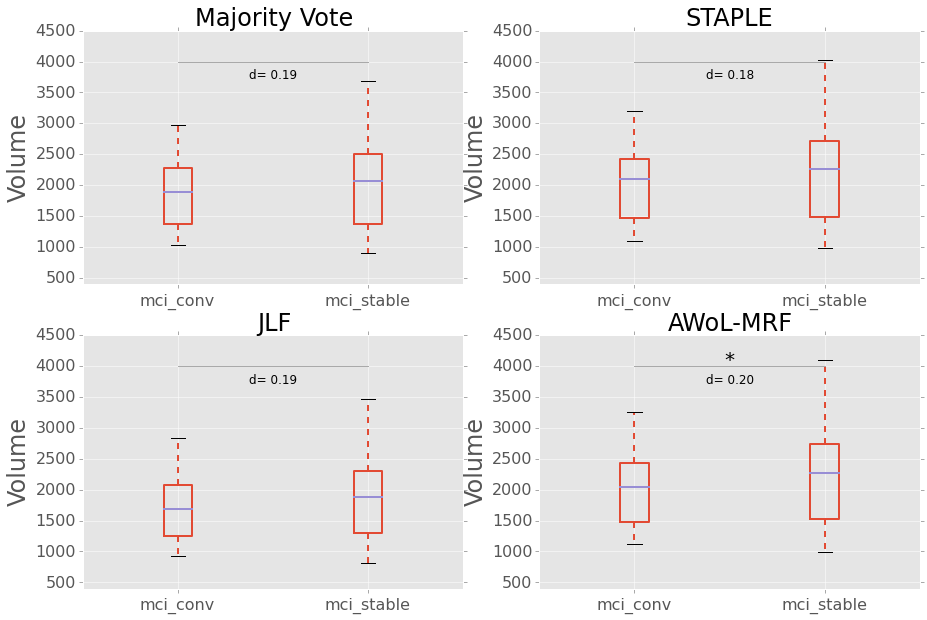

In [48]:
import pandas as pd
from matplotlib.artist import setp 
import itertools

df_array = [ pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]
methods = [Px_vol_LR_dict_maj,Px_vol_LR_dict_stpl,Px_vol_LR_dict_jlf,Px_vol_LR_dict_awol]
#methods = [Px_vol_LR_normTBV_dict_maj,Px_vol_LR_normTBV_dict_stpl,Px_vol_LR_normTBV_dict_jlf,Px_vol_LR_normTBV_dict_awol]
#methods = [Px_vol_LR_normICV_dict_maj,Px_vol_LR_normICV_dict_stpl,Px_vol_LR_normICV_dict_jlf,Px_vol_LR_normICV_dict_awol]

#methods = [Dx_vol_LR_dict_maj,Dx_vol_LR_dict_stpl,Dx_vol_LR_dict_jlf,Dx_vol_LR_dict_awol]
#methods = [Dx_vol_normICV_LR_dict_maj,Dx_vol_normICV_LR_dict_stpl,Dx_vol_normICV_LR_dict_jlf,Dx_vol_normICV_LR_dict_awol]
#methods = [Dx_vol_normTBV_LR_dict_maj,Dx_vol_normTBV_LR_dict_stpl,Dx_vol_normTBV_LR_dict_jlf,Dx_vol_normTBV_LR_dict_awol]

method_labels = ['Majority Vote', 'STAPLE', 'JLF','AWoL-MRF' ]
#Dx_grps = ['NL','MCI','Dementia']
Dx_grps = ['mci_conv','mci_stable']

#plt.figure()
#plt.style.use('ggplot')
fontsize_tiny = 12 # ticks
fontsize_small = 16 #legend
fontsize_med = 20 # axes labels
fontsize_big = 24 #title 
line_size_big = 4
line_size_med = 2
marker_size_big = 8
marker_size_med = 4
left_margin=[1,3,2]
sig_hlines_start = [.5,.167,.167]
sig_hlines_fin = [.833,.5,.833]
hline_height = [4200,4600,5000]
star_location = [2.5,1.5,2]
for m,mth in enumerate(methods):    
    results = getPairwiseStats(mth,Dx_grps)
    cohens_d = results['cohen_dict']
    signif_level = results['signif_level']
    signif_dict = results['signif_dict']
    
    print method_labels[m]
    print cohens_d, signif_dict    
#     print 'AD: ' + str(np.mean(mth['Dementia'])), 'LMCI: ' + str(np.mean(mth['MCI'])), 'CN: ' + str(np.mean(mth['NL']))
#     print 'AD: ' + str(np.std(mth['Dementia'])), 'LMCI: ' + str(np.std(mth['MCI'])), 'CN: ' + str(np.std(mth['NL']))
#     print(str.format('{0:.1f}', np.mean(mth['NL']))+'&'+str.format('{0:.1f}', np.std(mth['NL']))+'&['+
#           str.format('{0:.1f}', np.min(mth['NL']))+', '+str.format('{0:.1f}', np.max(mth['NL']))+']&'+          
#           str.format('{0:.1f}', np.mean(mth['MCI']))+'&'+str.format('{0:.1f}', np.std(mth['MCI']))+'&['+
#           str.format('{0:.1f}', np.min(mth['MCI']))+', '+str.format('{0:.1f}', np.max(mth['MCI']))+']&'+
#           str.format('{0:.1f}', np.mean(mth['Dementia']))+'&'+str.format('{0:.1f}', np.std(mth['Dementia']))+'&['+
#           str.format('{0:.1f}', np.min(mth['Dementia']))+', '+str.format('{0:.1f}', np.max(mth['Dementia']))+']' )
    
    print str.format('{0:.1f}', np.mean(mth['mci_conv']))+'&'+str.format('{0:.1f}', np.std(mth['mci_conv']))+'&['+str.format('{0:.1f}', np.min(mth['mci_conv']))+', '+str.format('{0:.1f}', np.max(mth['mci_conv']))          
    print str.format('{0:.1f}', np.mean(mth['mci_stable']))+'&'+str.format('{0:.1f}', np.std(mth['mci_stable']))+'&['+str.format('{0:.1f}', np.min(mth['mci_stable']))+', '+str.format('{0:.1f}', np.max(mth['mci_stable']))+']'
          
    plt.subplot(2,2,m+1)
    df_array[m] = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in mth.iteritems() ]))
    bplot = df_array[m].boxplot(column=Dx_grps, fontsize=fontsize_big)
   
    #plt.xlabel('Dx',fontsize=fontsize_med)
    plt.ylabel('Volume',fontsize=fontsize_big)
    plt.title(method_labels[m],fontsize=fontsize_big)
    #plt.ylim([400,5500])
    plt.ylim([400,4500])
    plt.xticks(fontsize=fontsize_small)
    plt.yticks(fontsize=fontsize_small)
    setp(bplot['boxes'], linewidth=2)
    setp(bplot['whiskers'], linewidth=2)
    setp(bplot['fliers'], linewidth=2)
    setp(bplot['medians'], linewidth=2)
    
    #['MCI v Dementia', 'NL v MCI', 'NL v Dementia']
    for c,cKey in enumerate(cohens_d.keys()):
#         plt.axhline(y=hline_height[c], xmin=sig_hlines_start[c], xmax=sig_hlines_fin[c],linewidth=1, color='darkgray')
#         plt.text(star_location[c], hline_height[c], signif_level[cKey],fontsize=fontsize_med,color='black')
#         plt.text(star_location[c], hline_height[c] - 280, str.format('d= {0:.2f}', cohens_d[cKey]), horizontalalignment='center',fontsize=fontsize_tiny,color='black')
        
        plt.axhline(y=4000, xmin=.25, xmax=.75,linewidth=1, color='darkgray')
        plt.text(1.5, 4000, signif_level[cKey], horizontalalignment='center',fontsize=fontsize_med,color='black')
        plt.text(1.5, 4000-280, str.format('d= {0:.2f}', cohens_d[cKey]), horizontalalignment='center',fontsize=fontsize_tiny,color='black')
#        plt.text(1.5, 600, 'cohen\'s d={:04.3f}'.format(cohens_d[cKey]), horizontalalignment='center', 
#                 fontsize=fontsize_med, color='slateblue')
        #plt.text(left_margin[c],500, cKey + ": " + str.format('{0:.2f}' , cohens_d[cKey]), 
        #         horizontalalignment='center', fontsize=fontsize_tiny, color='slateblue')
    #plt.savefig(base_dir + 'mci_conv_vs_nonconv.png', bbox_inches='tight')
    #plt.savefig(base_dir + 'Dx_volumetry.png', bbox_inches='tight')
#plt.show()

In [ ]:
Dx_grps = ['CN','LMCI','AD']
ba_method_labels = ['Majority Vote', 'STAPLE', 'JLF', 'AWoL-MRF']
ba_method_colors = ['slateblue', 'darkturquoise','darkgray', 'salmon','indianred','seagreen','wheat']

All_Dx_vol_LR_jlf = np.concatenate([Dx_vol_LR_dict_jlf['AD'],Dx_vol_LR_dict_jlf['LMCI'],Dx_vol_LR_dict_jlf['CN']])
All_Dx_vol_LR_awol = np.concatenate([Dx_vol_LR_dict_awol['AD'],Dx_vol_LR_dict_awol['LMCI'],Dx_vol_LR_dict_awol['CN']])

mean      = 0.5*(All_Dx_vol_LR_jlf + All_Dx_vol_LR_awol)
diff      = All_Dx_vol_LR_jlf - All_Dx_vol_LR_awol
md        = np.mean(diff)                   # Mean of the difference
sd        = np.std(diff, axis=0)

# plt.figure()
# #plt.subplot(2,2,1)
# plt.scatter(mean, diff, c=ba_method_colors[0],label='all Dx')
# plt.plot(mean, m*mean + b, '-', c=ba_method_colors[0],linewidth=line_size_med)
# plt.axhline(md,         linestyle='--', c=ba_method_colors[0],linewidth=line_size_med)
# plt.axhline(md + 2*sd,  linestyle=':', c=ba_method_colors[0],linewidth=line_size_med)
# plt.axhline(md - 2*sd,  linestyle=':', c=ba_method_colors[0],linewidth=line_size_med)
# plt.xticks(fontsize=fontsize_tiny)
# plt.yticks(fontsize=fontsize_tiny)
# plt.xlabel('0.5*(JLF + AWoL)',fontsize=fontsize_big)
# plt.ylabel('(JLF - AWoL)',fontsize=fontsize_big)
# plt.title('All Dx')
# print mean.shape

for d, dx in enumerate(Dx_grps):    
    x1 = np.array(Dx_vol_LR_dict_jlf[dx],float)
    x2 = np.array(Dx_vol_LR_dict_awol[dx],float)
    mean      = np.mean([x1,x2], axis=0)
    diff      = x1-x2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    # fit with np.polyfit
    m, b = np.polyfit(mean, diff, 1)
    print mean.shape
    #plt.subplot(2,2,d+2)
    plt.scatter(mean, diff, c=ba_method_colors[d+1],label=dx)
    plt.plot(mean, m*mean + b, '-', c=ba_method_colors[d+1],linewidth=line_size_med)
    plt.axhline(md,         linestyle='--', c=ba_method_colors[d+1],linewidth=line_size_med)
    plt.axhline(md + 2*sd,  linestyle=':', c=ba_method_colors[d+1],linewidth=line_size_med)
    plt.axhline(md - 2*sd,  linestyle=':', c=ba_method_colors[d+1],linewidth=line_size_med)
    plt.xticks(fontsize=fontsize_tiny)
    plt.yticks(fontsize=fontsize_tiny)
    plt.xlabel('0.5*(JLF + AWoL)',fontsize=fontsize_big)
    plt.ylabel('(JLF - AWoL)',fontsize=fontsize_big)
    plt.title(dx)
    plt.legend(fontsize=fontsize_med)
    
#plt.show()

In [ ]:
mat_contents.keys()

In [ ]:
print bplot_keys

In [49]:
#import total brain volume
from collections import defaultdict
import statsmodels.formula.api as smf
#Dx_grps = ['mci_conv','mci_stable']
#test_df = awol_df[(awol_df.DX =='NL') | (awol_df.DX =='MCI') |(awol_df.DX =='Dementia')]
#test_df = awol_df #[(awol_df.PX ==1) | (awol_df.PX ==0)]

for test_df in [maj_df,stpl_df,jlf_df,awol_df]:
    print "----------"
    est = smf.ols(formula='HC_LR ~ Sex + Age + TBV + C(PX, Treatment(reference=0))', data=test_df).fit()
    print 't_vals: {}'.format(est.tvalues)
    print " " 
    print 'p_vals: {}'.format(est.pvalues)

----------
t_vals: Intercept                               1.223155
Sex[T.M]                                3.209172
C(PX, Treatment(reference=0))[T.1.0]   -1.708970
Age                                    -0.479441
TBV                                     3.166888
dtype: float64
 
p_vals: Intercept                               0.222334
Sex[T.M]                                0.001491
C(PX, Treatment(reference=0))[T.1.0]    0.088601
Age                                     0.632011
TBV                                     0.001717
dtype: float64
----------
t_vals: Intercept                               1.120911
Sex[T.M]                                2.967713
C(PX, Treatment(reference=0))[T.1.0]   -1.616520
Age                                    -0.372091
TBV                                     3.173257
dtype: float64
 
p_vals: Intercept                               0.263329
Sex[T.M]                                0.003271
C(PX, Treatment(reference=0))[T.1.0]    0.107158
Age            

In [ ]:
-------------
---AWoL------
t_vals: Intercept                       1.172922
Sex[T.M]                                2.823321
C(PX, Treatment(reference=1))[T.0.0]    1.737461
Age                                    -0.970619
TBV                                     3.103818
dtype: float64
 
p_vals: Intercept                       0.241917
Sex[T.M]                                0.005126
C(PX, Treatment(reference=1))[T.0.0]    0.083508
Age                                     0.332654
TBV                                     0.002125
dtype: float64

--No TBV--
t_vals: Intercept                               6.447935
Sex[T.M]                                5.906962
C(PX, Treatment(reference=0))[T.1.0]   -1.777036
Age                                    -1.800235
dtype: float64
 
p_vals: Intercept                               5.581119e-10
Sex[T.M]                                1.100356e-08
C(PX, Treatment(reference=0))[T.1.0]    7.674510e-02
Age                                     7.299614e-02
dtype: float64
    
------------
---JLF------
t_vals: Intercept                               5.387797
Sex[T.M]                                0.696518
C(PX, Treatment(reference=1))[T.0.0]    1.620738
Age                                     0.013242
TBV                                     0.687761
dtype: float64
 
p_vals: Intercept                               1.612216e-07
Sex[T.M]                                4.867337e-01
C(PX, Treatment(reference=1))[T.0.0]    1.063000e-01
Age                                     9.894450e-01
TBV                                     4.922238e-01
dtype: float64
    
--No TBV--
t_vals: Intercept                               10.358278
Sex[T.M]                                 1.424169
C(PX, Treatment(reference=0))[T.1.0]    -1.638089
Age                                     -0.169783
dtype: float64
 
p_vals: Intercept                               2.991436e-21
Sex[T.M]                                1.556059e-01
C(PX, Treatment(reference=0))[T.1.0]    1.026221e-01
Age                                     8.653138e-01
dtype: float64

------------
---STPL------    
t_vals: Intercept                               0.903426
Sex[T.M]                                2.663489
C(PX, Treatment(reference=0))[T.1.0]   -1.511675
Age                                    -0.432273
TBV                                     3.360229
dtype: float64
 
p_vals: Intercept                               0.367159
Sex[T.M]                                0.008230
C(PX, Treatment(reference=0))[T.1.0]    0.131865
Age                                     0.665911
TBV                                     0.000899
dtype: float64
    
--no TBV
t_vals: Intercept                               5.856214
Sex[T.M]                                5.870254
C(PX, Treatment(reference=0))[T.1.0]   -1.519095
Age                                    -1.318838
dtype: float64
 
p_vals: Intercept                               1.459318e-08
Sex[T.M]                                1.354561e-08
C(PX, Treatment(reference=0))[T.1.0]    1.299824e-01
Age                                     1.884111e-01
dtype: float64

------------
---MAJ------
t_vals: Intercept                               1.019704
Sex[T.M]                                2.930042
C(PX, Treatment(reference=0))[T.1.0]   -1.583340
Age                                    -0.544406
TBV                                     3.338019
dtype: float64
 
p_vals: Intercept                               0.308831
Sex[T.M]                                0.003695
C(PX, Treatment(reference=0))[T.1.0]    0.114578
Age                                     0.586636
TBV                                     0.000969
dtype: float64
    
--no TBV

t_vals: Intercept                               6.023554
Sex[T.M]                                6.202416
C(PX, Treatment(reference=0))[T.1.0]   -1.625895
Age                                    -1.423675
dtype: float64
 
p_vals: Intercept                               5.877351e-09
Sex[T.M]                                2.208652e-09
C(PX, Treatment(reference=0))[T.1.0]    1.051976e-01
Age                                     1.557535e-01
dtype: float64




In [ ]:
test_df = jlf_df #[(jlf_df.DX =='NL') | (awol_df.DX =='MCI') |(awol_df.DX =='Dementia')]
#est = smf.ols(formula='HC_LR ~ Sex + Age + TBV + + C(DX, Treatment(reference="NL"))', data=test_df).fit()
est = smf.ols(formula='HC_LR ~ Sex + Age + TBV + C(PX, Treatment(reference=1))', data=test_df).fit()
est.summary()

In [ ]:
# Test out ADNI data from CSV for certain covariates

tbv_file_path = '/data/chamal/projects/nikhil/data/neuroimage/adni_vol/ADNI1_1.5T_with_scaled_2.csv'
csv_data = pd.read_csv(tbv_file_path,sep=';')
baseline_adni1_data = csv_data[csv_data.VISCODE =='bl']

dx_dict = pd.Series(baseline_adni1_data.DX.values,index=baseline_adni1_data.RID).to_dict()
ICV_dict =  pd.Series(baseline_adni1_data.ICV.values,index=baseline_adni1_data.RID).to_dict()
TBV_dict =  pd.Series(baseline_adni1_data.WholeBrain.values,index=baseline_adni1_data.RID).to_dict()
Age_dict =  pd.Series(baseline_adni1_data.Age.values,index=baseline_adni1_data.RID).to_dict()
Sex_dict =  pd.Series(baseline_adni1_data.Sex.values,index=baseline_adni1_data.RID).to_dict()

img_idx=1001
i=0
#meth_df = pd.DataFrame(columns=('ID', 'Age', 'Sex', 'TBV', 'ICV', 'HC_L', 'HC_R', 'HC_LR'))
cols = meth_df.columns
row = pd.Series([img_idx, Age_dict[img_idx], Sex_dict[img_idx], ICV_dict[img_idx], 
                                          TBV_dict[img_idx],float(maj_vols_L[i]),float(maj_vols_R[i]),
                                          0.5*(float(maj_vols_L[i])+float(maj_vols_R[i]))], index=cols)
print row
meth_df.loc[len(meth_df)] = row
meth_df

In [ ]:
stpl_df

In [ ]:
285+65